<a href="https://colab.research.google.com/github/melodyrous/MIASHS2/blob/main/traitement_images/journee_deep_vEtudiant_truetrue_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

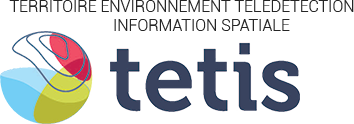

#Objectifs du tutoriel

Dans ce cours nous allons travailler sur un problème de classification d'images. Pour cela nous utiliserons la base de données Caltech256 (http://www.vision.caltech.edu/Image_Datasets/Caltech256/) qui est composée de 256 classes. Contrairement au tutoriel de ce matin qui se basait sur PyTorch nous allons dans ce TP utiliser les framework Tensorflow et Keras pour créer et entraîner nos modèles. 

> Dans un premier temps nous allons construire un Réseau neuronal convolutif (CNN) que nous entraînerons sur une sous-partie de la base. A partir de ce modèle nous analyserons les effets de l'augmentation de données sur les images.


> Dans un second temps nous évaluerons si les caractéristiques trouvées par le CNN sont pertinentes pour d'autres problèmes de classification d'images. Pour cela, nous effectuerons un apprentissage par transfert (transfert learning) et nous analyserons à la fois les performances du réseau et également la pertinence des caractéristiques construites. 

> Enfin, afin de comprendre les informations présentes dans les dernières couches des CNN nous chercherons à reconstruire une image à partir de ses espaces latents très représentatifs. 





---







Avant toute chose nous allons télécharger la base de données que nous allons utiliser dans notre environnement Colab. 

In [1]:
!mkdir /root/.kaggle/
!echo "{\"username\":\"jeromepasquet\",\"key\":\"0989eedbd3dceb70177e900e6a04afec\"}"> /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!cat /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/caltech256
!unzip -qq  caltech256.zip

{"username":"jeromepasquet","key":"0989eedbd3dceb70177e900e6a04afec"}
100% 2.11G/2.12G [00:23<00:00, 15.8MB/s]
100% 2.12G/2.12G [00:23<00:00, 96.5MB/s]


Nous téléchargeons également certains modèles pré-entrainés que nous utiliserons. 

In [2]:
#https://we.tl/t-UL9Ol0Fwyk
!wget 'LIEN' -O net.tar
!tar xvf net.tar
!ls

--2021-10-06 12:18:55--  http://lien/
Resolving lien (lien)... failed: Name or service not known.
wget: unable to resolve host address ‘lien’
tar: This does not look like a tar archive
tar: Exiting with failure status due to previous errors
256_objectcategories  caltech256.zip  sample_data
256_ObjectCategories  net.tar


Comme nous pouvons le voir à l'aide de la commande 'ls' les données sont triées par classe. A chaque classe correspond un nom et un identifiant unique qui est compris entre 001 et 256.

In [3]:
!ls 256_ObjectCategories  

001.ak47		 087.goldfish	      173.rifle
002.american-flag	 088.golf-ball	      174.rotary-phone
003.backpack		 089.goose	      175.roulette-wheel
004.baseball-bat	 090.gorilla	      176.saddle
005.baseball-glove	 091.grand-piano-101  177.saturn
006.basketball-hoop	 092.grapes	      178.school-bus
007.bat			 093.grasshopper      179.scorpion-101
008.bathtub		 094.guitar-pick      180.screwdriver
009.bear		 095.hamburger	      181.segway
010.beer-mug		 096.hammock	      182.self-propelled-lawn-mower
011.billiards		 097.harmonica	      183.sextant
012.binoculars		 098.harp	      184.sheet-music
013.birdbath		 099.harpsichord      185.skateboard
014.blimp		 100.hawksbill-101    186.skunk
015.bonsai-101		 101.head-phones      187.skyscraper
016.boom-box		 102.helicopter-101   188.smokestack
017.bowling-ball	 103.hibiscus	      189.snail
018.bowling-pin		 104.homer-simpson    190.snake
019.boxing-glove	 105.horse	      191.sneaker
020.brain-101		 106.horseshoe-crab   192.snowmobile
021.bread



---
# Lecture des données

Dans un premier temps nous allons diviser la base d'apprentissage en deux bases distinctes. La base A contiendra les objets avec les 200 premiers labels -- c'est à dire ceux qui ont un identifiant entre 1 et 200 -- et la base B contiendra les objets avec les labels restants entre 201 et 256. 

Chacune des bases, A et B, est ensuite divisée en une base d'entraînement contenant 80% des objets et une base de validation contenant 20% des objets. 

In [4]:
from sklearn.model_selection import train_test_split
import glob


def split_database(debut_label, fin_label, proba_train):
    chemin = "./256_ObjectCategories/"
    labels_name = []
    x         = []
    y         = []
    for l in range(debut_label, fin_label, 1):
        label = str(l).rjust(3, '0')
        labels_name.append(glob.glob(chemin+label+".*")[0].split("/")[-1])
        tmp = glob.glob(chemin+label+".*/*.jpg")
        x += tmp
        y += [l-debut_label]*len(tmp)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=proba_train, random_state=42)
    return [X_train, y_train], [X_test, y_test], labels_name


train_database_a, val_database_a , labels_name_a= split_database(1,201,0.2)
train_database_b, val_database_b , labels_name_b= split_database(201,257,0.2)


In [5]:
print(len(train_database_a[0]), len(val_database_a[0]))
print(len(train_database_b[0]), len(val_database_b[0]))

18258 4565
5565 1392


Nous définissons quelques constantes que nous utiliserons pas la suite. 

In [6]:
BATCH_SIZE = 32
SIZE = 192
EPOCH= 2

#Générateur  / Dataset

Afin de gérer les entrées du réseau nous allons utiliser la classe Dataset définie dans le package data de tensorflow (https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

> Dans un premier temps nous définissons une fonction 'read_function' dont l'utilité est de lire une image donnée. Au sein d'un même paquet (mini-batch) toutes les images doivent avoir la même dimension. Pour cela nous redimensionnons toutes les images avec une taille de SIZE x SIZE. Durant le TP nous avons fixé la valeur de SIZE à 196 afin de permettre à vos futurs modèles de fonctionner sur Colab. 

> Dans un second temps vous allez définir la fonction 'create_dataset' qui prend en paramètre la liste des chemins des images à charger et leur vérité terrain. En utilisant la fonction 'tf.data.Dataset.from_tensor_slices' vous construirez un objet de type Dataset associant les chemins des images à leur classe. 

> Enfin vous utiliserez la méthode 'map'(https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) afin de transformer chaque chemin vers un objet en une image redimensionnée manipulable par tensorflow.
De plus vous utiliserez les méthodes suivantes :
*   shuffle : afin de mélanger votre base.
*   cache : afin de conserver en mémoire les objets/images déjà chargés
*   prefetch : afin d'optimiser le traitement et de permettre au CPU de précharger les données pendant que le GPU effectue l'entraînement. 




---
**Exercice :** Veuillez compléter la fonction read_function(...) afin que celle-ci retourne une image redimensionnée et son label associé.

---




In [30]:
import tensorflow as tf

# def read_function(filename, label):
#     image = tf.keras.utils.load_img(
#       filename,
#       grayscale=False,
#       color_mode='rgb',
#       target_size=(SIZE,SIZE),
#     interpolation='nearest'
#     )
#     image = tf.keras.preprocessing.image.img_to_array(image)
#     image = np.array([image]) 
#     return image, label


def read_function(filename, label):

  image = tf.image.decode_jpeg(tf.io.read_file(filename), channels=3)
  image = tf.image.resize(image, (SIZE, SIZE), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False)
  return image, label



---
**Exercice :** Veuillez compléter la fonction create_dataset(..) afin que celle-ci retourne un générateur Keras retournant les images redimensionnées sous la forme de batch. N'oublier pas d'inclure 'shuffle' afin de mélanger la base à chaque époque. 

---




In [31]:
def create_dataset(data):
  images = tf.constant(data[0]) 
  labels = tf.constant(data[1]) 
  dataset = tf.data.Dataset.from_tensor_slices((images, labels))
  dataset = dataset.map(read_function, num_parallel_calls=tf.data.AUTOTUNE) #.cache()
  dataset = dataset.shuffle(buffer_size = len(data[0])).prefetch(buffer_size=2) #prefetch
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  return dataset

gen_train_A = create_dataset(train_database_a)
gen_val_A = create_dataset(val_database_a)
gen_train_B = create_dataset(train_database_b)
gen_val_B = create_dataset(val_database_b)


#Visualisation des données

Il est désormais très simple avec un générateur de visualiser et d'itérer sur les données. Nous proposons ici d'afficher toutes les images correspondantes à un paquet et de rajouter en titre le nom du label correspondant. 


---
**Exercice :** Affichez les images du premier paquet contenu dans la base 'gen_train_A'.

---




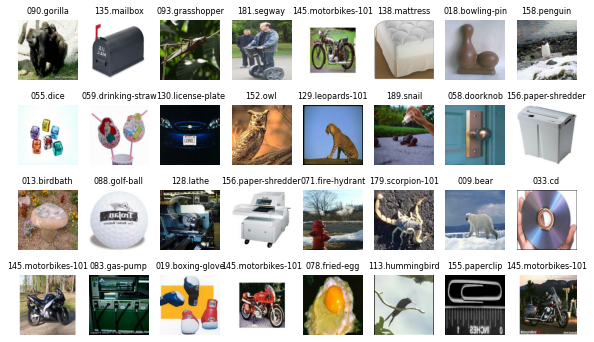

In [34]:
import matplotlib.pyplot as plt
import numpy as np
for batch in gen_train_A.take(1):
  x, y = batch
  plt.figure(figsize=(10,6))
  for i in range(0, min(8*4, x.shape[0])):
    plt.subplot(4,8, i+1)
    plt.imshow(np.array(x[i]).astype(int))
    plt.title(str(labels_name_a[y[i]]), fontsize=8)
    plt.axis("off
    ")

  plt.show()
  



#Le modèle

Nous allons ici définir notre modèle Keras. Celui-ci sera composé d'une entrée, dans notre cas d'une image, et d'une sortie dans notre cas d'un ensemble de caractéristiques représentant un score associé à chaque label. Les couches à l'intérieur de notre modèle formeront notre architecture, dans notre cas il s'agira d'un CNN. 

## Les couches de convolution

Les couches de convolution sont constituées d'un ensemble de neurones de convolution. Chaque neurone de convolution va effectuer une opération simple de convolution sur les caractéristiques en entrée de la couche. Une convolution est une opération locale s'appliquant sur l'ensemble des positions de la donnée d'entrée de manière indépendante et permettant de prendre en considération l'information de voisinage. 

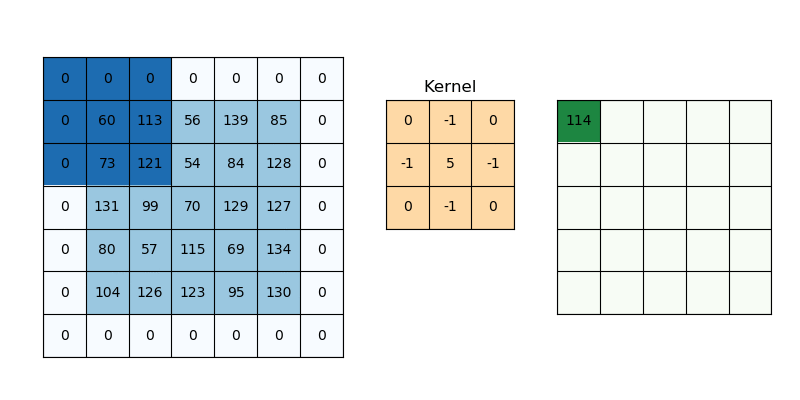

Source : https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

Le noyau (kernel) de chaque neurone de convolution se met à jour suivant les mêmes règles de rétro-propagation d'erreur que celles vues ce matin. L'objectif est de mettre en avant certaines caractéristiques / motifs propres aux images. Les sorties des neurones de convolution sont appelées cartes de caractéristiques (features maps). Au sein du réseau les couches de convolution vont prendre en entrée plusieurs images ou cartes de caractéristiques. Il est donc nécessaire d'étendre la convolution 2D déjà vue pour prendre en considération les différentes cartes de caractéristiques. Pour cela, chaque neurone va convoluer de manière indépendante les différentes entrées puis sommer les résidus. L'image ci-après illustre ce phénomène où on voit une première couche de convolution ne prenant en considération qu'une image en entrée et une seconde couche de convolution prenant en entrée les trois cartes de caratéristiques issues de la première. 

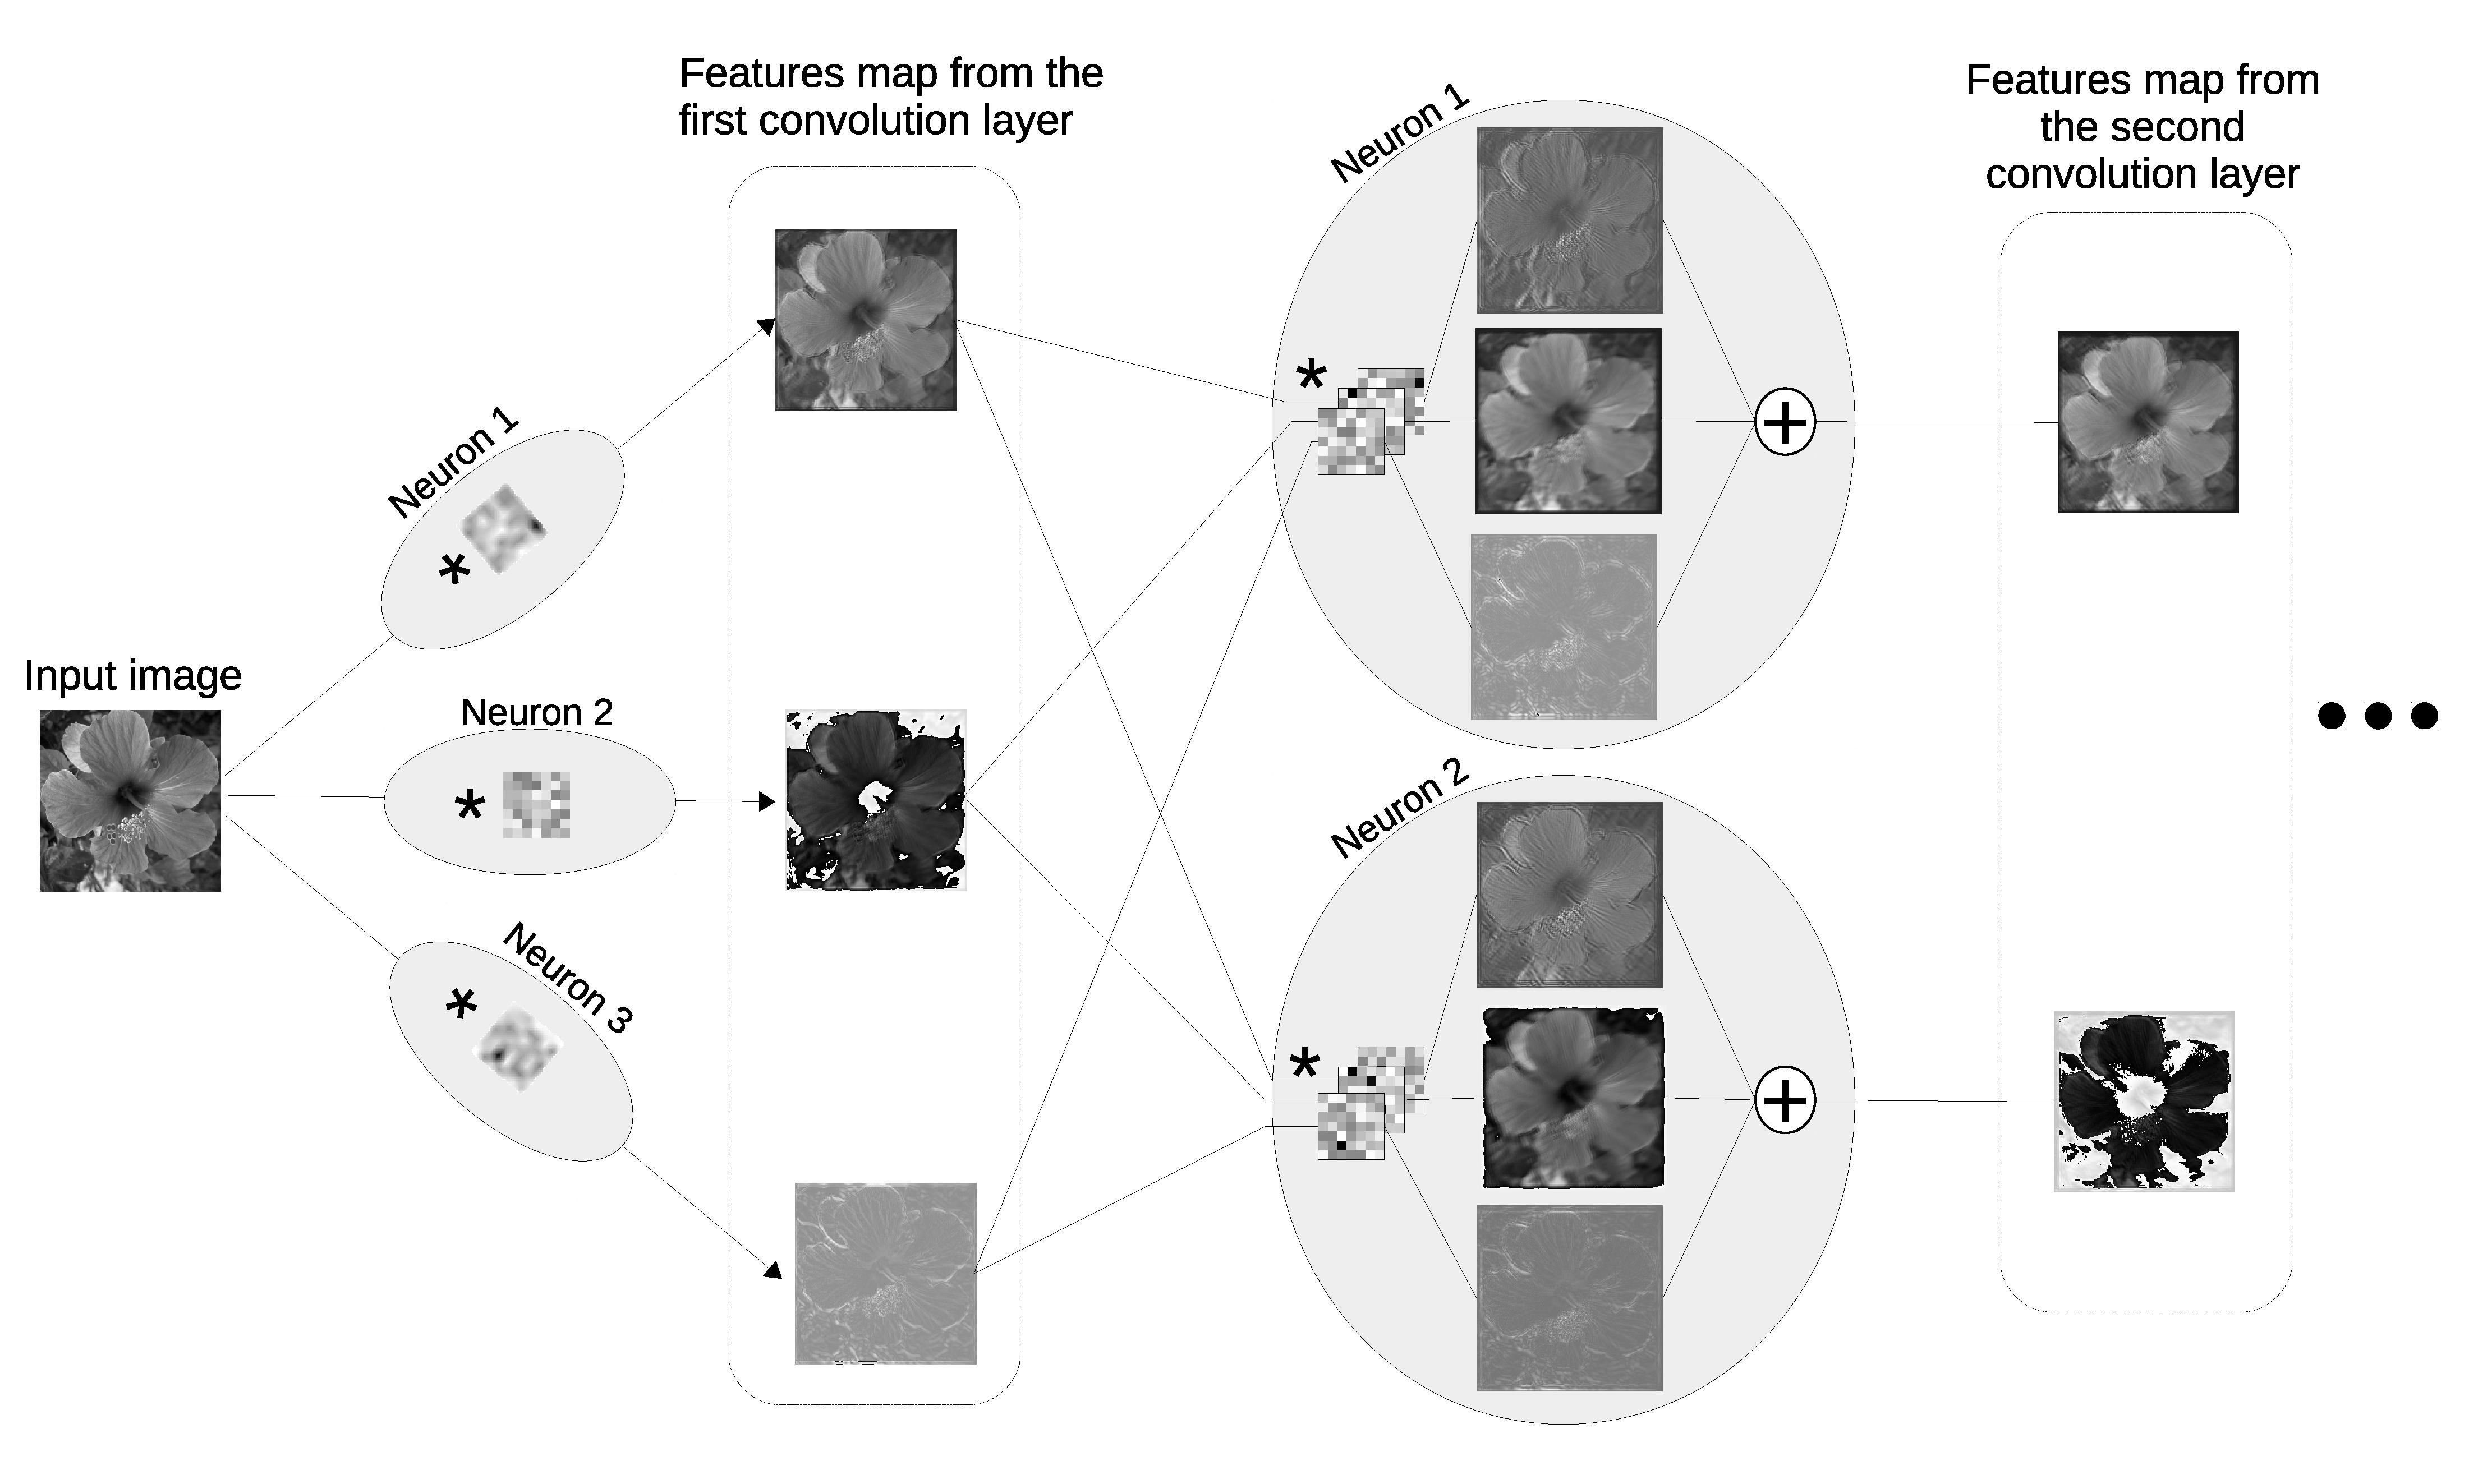

> Sous Keras une manière d'utiliser les couches de convolution est d'utiliser la classe Conv2D (tf.keras.layers.Conv2D). Celle-ci permet de prendre en considération de nombreux paramètres comme :
*   la taille du noyau (kernel_size)
*   le nombre de neurones (filters)
*   la vitesse de déplacement du noyau sur la fenêtre définie par le paramètre 'strides'
*   De manière similaire aux couches 'dense' il est nécessaire d'appliquer une fonction d'activation. Cela peut-être réalisé très simplement via le paramètre 'activation'. Par exemple activation='relu'. 
*   Lorsqu'une convolution est appliquée sur une image celle-ci ne peut pas s'appliquer sur les bords de l'image. Il peut être intéressant de rajouter une bordure aux images afin de conserver la dimension de l'image. Plusieurs stratégies peuvent etre envisagées. L'une d'entres elles consiste à rajouter des 0 autour de l'image et peut-être effectuée via l'argument 'padding'.
*    On peut donner un nom explicite à chaque convolution (via 'name'). Cela n'est pas obligatoire car tensorflow peut générer des noms par défaut. 

## Le sous-échantillonnage
Les couches de sous-échantillonnage permettent de quantifier l'information et de réduire la taille des cartes de caractéristiques. La réduction des tailles des cartes de caractéristiques permettra de créer des réseaux plus profonds pouvant donc apprendre des concepts plus complexes. Cette opération peut se faire en utilisant différents types d'opérations. Une des plus courantes est l'utilisation de l'opérateur Maximum via la classe layers.MaxPool2D (https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

## Les couches Dense
Les couches denses vues ce matin peuvent s'implémenter facilement sous Keras en utilisant la classe layers.Dense (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

## Notre architecture

Nous allons implémenter le modèle décrit par le tableau ci-après. 

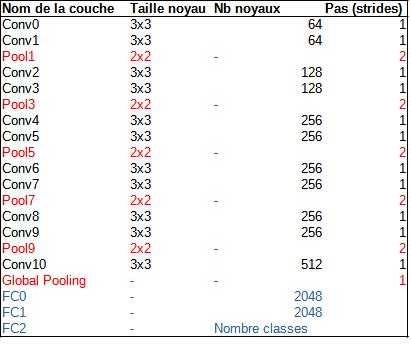

Notons que le pooling utilisé est celui par le maximum et que la fonction d'activation utilisée est la ReLU.

Le modèle que nous souhaitons créer est donc séquentiel. Chaque couche prend en entrée uniquement les cartes de caractéristiques de la couche précédente. Dans ce contexte nous pouvons utiliser la classe models.Sequential de Keras (https://keras.io/api/models/sequential/). Cette classe agit comme une liste dans laquelle nous pouvons ajouter les couches les unes après les autres en commençant par la première et en finissant par la couche de sortie. 

---
**Exercice :** Implémenter le réseau décrit dans le tableau ci-dessus. 

---




In [ ]:
from tensorflow.keras import  layers, models


def createModel(prefix, nn=10):
  model = models.Sequential()
  model.add(tf.keras.Input(shape=(SIZE,SIZE,3,)))
  model.add(layers.Conv2D(kernel_size=3, filters=64, strides=1, activation='relu') # 3*3(noyeau) *3(entree) *64 + 64(biais)
  model.add(layers.Conv2D(kernel_size=3, filters=64, strides=1, activation='relu') # 3*3 *64 *64 + 64
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(kernel_size=3, filters=128, strides=1, activation='relu') #3*3*64*128 + 128
  model.add(layers.Conv2D(kernel_size=3, filters=128, strides=1, activation='relu')
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(kernel_size=3, filters=256, strides=1, activation='relu')
  model.add(layers.Conv2D(kernel_size=3, filters=256, strides=1, activation='relu')
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(kernel_size=3, filters=256, strides=1, activation='relu')
  model.add(layers.Conv2D(kernel_size=3, filters=256, strides=1, activation='relu')
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(kernel_size=3, filters=256, strides=1, activation='relu')
  model.add(layers.Conv2D(kernel_size=3, filters=256, strides=1, activation='relu')
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(kernel_size=3, filters=512, strides=1, activation='relu'))
  model.add(layers.GlobalAveragePooling2D(name='gp'))

  model.add(layers.Dense(2018, activation='relu', )) #512 * 2048 + 2048


  return model



  



# Apprentissage du modèle 

## Le pas d'apprentissage
Maintenant que nous avons défini notre modèle nous allons mettre en place l'ensemble des règles permettant d'effectuer l'apprentissage. Pour cela, nous allons définir un ensemble de méta paramètres comme la taille des paquets (mini-batch), l'évolution du learning rate, etc. 

Concernant l'évolution du learning rate nous souhaitons mettre en place la règle suivante : 

$$
\epsilon=\begin{cases}
10^{^{-4}} & si\ e<\frac{e_{max}}{2}+1\\
10^{^{-5}} & si\ \frac{e_{max}}{2}+1\leq e<\frac{2\times e_{max}}{3}+1\\
10^{^{-6}} & sinon
\end{cases}
$$
avec $\epsilon$ le pas d'apprentissage (learning rate), $e$ le numéro de l'époque en cours et $e_{max}$ le nombre total d'époques.

Une fois cette fonction définie nous la transmettrons à un objet 'LearningRateScheduler' qui sera (si on le souhaite) automatiquement appelé par tensorflow lors de l'apprentissage. 

---
**Exercice :** Implémenter la fonction de perte décrite pas l'équation.

---




In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
def step_decay(epoch):
    #Compléter
    return LEARNING_RATE
lrate = LearningRateScheduler(step_decay, verbose=1)





## Apprentissage du modèle 
> Nous pouvons ici créer notre modèle. Une fois notre modèle construit nous lui affectons une fonction de perte qui va définir la règle à suivre pour minimiser les poids. De plus, nous pouvons lui affecter un optimiseur (ici "Adam") qui permet de calculer et mettre à jour les différents paramètres en fonction de l'erreur rétro-propagée. L'optimiseur Adam peut être vu comme une extension de SGD qui adapte le pas de mise à jour pour chaque variable. Ce tutoriel ne va pas plus détailler cette méthode d'optimisation dont vous trouverez une définition complète dans le papier publié à ICLR 2015 : *Adam: A Method for Stochastic Optimization* de Diederik P. Kingma et Jimmy Ba.

> De plus nous constatons que nous pouvons donner des métriques à calculer. Celles-ci ne seront pas utilisées pour mettre à jour les poids (et ne peuvent pas forcement l'être car elle ne sont pas dérivables ;) ) mais elles permettent d'évaluer les performances de notre modèle. 

> A ce stade le modèle est alloué et initialisé en mémoire VRAM (si vous utilisez des cartes graphiques nvidia). Vous pouvez  vérifier cela en regardant l'utilisant de votre GPU via la commande 'nvidia-smi'. 

> Vous pouvez maintenant lancer la méthode 'fit' qui va effectuer l'apprentissage. 

---
**Exercice :** Déclarer, initier et entraîner votre modèle en utilisant les fonctions createModel, compile et fit. 

---




In [ ]:

#Compléter



## Visualiser son modèle

Il est très simple sous Keras de visualiser et d'analyser son modèle. Vous pouvez utiliser la méthode summary() ou utiliser la fonction 'tf.keras.utils.plot_model'. 

---
**Exercice :** Tester les fonctions décrites pour visualiser votre architecture. Puis répondez aux questions suivantes : 

*   Combien de paramètres comporte votre modèle?
*   Quel est la dimension des cartes de caratéristiques en sortie de la couche 'Conv9'. 



---




In [ ]:

#Compléter


## Visualiser les résultats
Les résultats des différentes valeurs des métriques et des fonctions de perte sont stoqués dans la table de hashage 'history_a'. Nous pouvons donc très facilement visualiser l'évolution des résultats au cours du temps. 

---
**Exercice :** En utilisant les résultats stockés dans history_a.history affichez l'évolution de la fonction de perte et des différentes métriques. 
Le modèle converge-t-il? 


---




In [ ]:
#Compléter


# Temps de convergence

Comme vous pouvez le constater après seulement quelques époques le modèle n'a pas convergé. Il serait nécessaire de laisser le réseau s'entraîner un plus grand nombre d'époques. Cependant entraîner un modèle de deep learning est une tâche coûteuse malgré l'utilisation des GPU. Aussi vous pouvez utiliser des modèles que j'ai préalablement entrainés dans les mêmes conditions que vous pendant 50 époques. 

In [ ]:
model_classi_a = tf.keras.models.load_model("model_classi_a.h5")
history_a = np.load("history_a.npy", allow_pickle=True).item()

Nous pouvons maintenant analyser à nouveau les différents résultats. Soyez particulièrement attentifs à la comparaison entre les performances sur la base d'entaînement et celles sur la base de validation. 

*Note technique : La sauvegarde ne contient que la hashmap équivalente à history_b.history*

---
**Exercice :** Affichez l'évolution des performances du réseau déjà entraîné. Le réseau semble sur-apprendre, cela impacte-t-il les performances ?



---




In [ ]:
plt.subplot(131)
#Compléter avec Accuracy
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.05])
plt.subplot(132)
#Compléter avec Accuracy top-5
plt.xlabel('Epoch')
plt.ylabel('Accuracy top-5')
plt.ylim([0.0, 1.05])
plt.subplot(133)
#Compléter avec loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Conclusion : On constate qu'après plusieurs époques ($\simeq$ 25) et notamment lorsque le learning rate décroit, le modèle se stabilise à sa performance maximale. Les époques suivantes n'améliorent pas la classification et n'augmentent pas l'erreur de généralisation. 

## Robustesse et invariance

> Une question primordiale en traitement de l'image est la suivante : notre modèle est-il robuste aux différentes transformations applicables sur une image? Pour répondre à cette question nous allons nous focaliser sur les rotations 'entières' c'est à dire celles avec un angle de 90° et sur les transpositions mirroirs. 

> Pour visualiser les effets de ces transformations nous allons projeter via une t-SNE les caractéristiques données par une couche du CNN dans un espace à deux dimensions. Nous pourrons ensuite facilement représenter les objets par des points et analyser les distances entres deux objets identiques ayant subis une ou plusieurs transformations (rotations). 

### Implémentation

Afin d'extraire les caractéristiques d'une couche (nommée "couche d'intérêt") de notre modèle (nommé 'model_classi_a')  nous devons créer un nouveau modèle dont l'entrée est similaire à celle de 'model_classi_a' mais dont la sortie est la sortie de la couche d'intérêt. 


*   Pour créer un modèle nous utiliserons le schéma suivant : 
    
    
$\ \ \ \ \ \ \ $ *model_ = models.Model(inputs=..., outputs=...)*
*   Pour accèder à la sortie d'une couche dont on connait le nom nous pouvons utiliser la fonction suivante : 
  
$\ \ \ \ \ \ \ $ *model_classi_a.get_layer(Nom de la couche d'intérêt).output*






---
**Exercice :** Compléter la fonction 'tracer_tsne_rotation' afin que celle-ci retourne les caractéristiques d'une couche donnée des images de la base de validation qui auront subies des transformations. 
Notons que nous calculons les caractéristiques que pour les couches labels_keep.



---






In [ ]:
from sklearn.manifold import TSNE

def tracer_tsne_rotation(model, dataset, name_predict_layer, size_predict_layer, labels_keep):
  features_ = np.empty((0, size_predict_layer))
  labels_   = np.empty((0))

  #Construire un modèle permettant de retourner les cartes de caratéristiques voulues. 

  for i_,el in enumerate(dataset.repeat(1)):
    x, y = el
    wrong = np.zeros((y.shape[0])).astype(np.bool)
    for _, l in enumerate(labels_keep):
      wrong = (wrong) | (y==l)

    #On ne conserve que les labels dans 'labels_keep'
    if np.sum(wrong):
      x = x[wrong]
      y = y[wrong]
      
      x_tmp = []
      for i in range(0, x.shape[0]):
        img =  x[0]
        img0=  img
        #Tourner et transposer l'image selon différentes directions (img1, img2, etc...)

        l = [img0,img1,img2,img3,img4,img5,img6,img7]
        x_tmp+=l
    
      x = tf.stack(x_tmp, axis=0)  

      #Effectuer la prédiction puis concaténer la à 'features_'
      labels_ = np.concatenate((labels_, y ), axis=0)
  return features_,labels_ 

### Projection t-SNE
La projecion t-SNE se fera en utilisant le package correspondant dans sklearn. 

---
**Exercice :** Effectuer la transformation dans un espace 2D via une t-SNE. 

---






In [ ]:
#A compléter

### Visualisation

L'objectif de la visualisation est d'analyser si le même objet vu selon des orientations différentes se trouve dans la même zone de l'espace projeté. De plus, nous souhaitons vérifier que la distance entre deux classes différentes est la plus grande possible. 

---
**Exercice :** Proposez deux visualisations : 
*   Une première permettant de voir comment les classes sont séparées sans prendre en considération les transformations. 
*   Une seconde permettant de visualiser les positions des 100 premiers objets (avec et sans transformation).



---






In [ ]:
#A compléter

---
**Exercice :** Proposer une métrique permettant de calculer la dispersion des caractéristiques issues du même objet. 

---






In [ ]:
#A compléter

# Augmentation de données

Nous allons chercher à réduire l'écart entre les caractéristiques issues d'un objet et les caractéristiques provenant de ce même objet mais ayant subi un ensemble de transformations. Pour cela nous allons effectuer de l'augmentation de données c'est à dire transformer aléatoirement les données en entrée afin que le réseau ne sur-apprenne pas une même représentation. 

Il est très simple via la méthode 'map' des dataset d'appliquer un ensemble de transformations. Certaines sont déjà implémentées comme des rotations d'angles aléatoires, des zooms, du bruits etc. Toutes ces classes héritent des propriétés des PreprocessingLayer dont vous trouverez la description ici https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/PreprocessingLayer. 

Dans notre cas nous allons implémenter notre propre couche afin d'effectuer de l'augmentation de données en n'utilisant que des rotations avec un angle multiple de 90° et des transpositions. 

---
**Exercice :** Complétez la fonction RandomLayer afin que celle-ci ait une probabilité de 4/10 de n'effectuer aucune transformation et une chance sur 10 d'effectuer une transformation de chaque type définie dans la fonction 'tracer_tsne_rotation'.

---






In [ ]:

class RandomLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, img):
        batch = []
        for i in range(0, BATCH_SIZE):
            #Effectuer les différentes transformations sur img[i]
            #Rajouter les images transformées à la liste 'batch'
        return tf.stack(batch, axis=0)



data_augmentation = tf.keras.Sequential([
  RandomLayer()
])

#Créer la base 'gen_train_A_dataug' qui va effectuer l'augmentation de données



---
**Exercice :** Afficher le premier paquet d'images avec les transformations. 

---






In [ ]:
#Compléter


---
**Exercice :** Une fois notre générateur prêt nous pouvons effectuer l'apprentissage d'un nouveau modèle. 

---






In [ ]:
#Compléter

Comme pour le premier entraînement sans l'augmentation de données le réseau n'a pas le temps de converger en seulement 2-3 époques. Vous pouvez charger le réseau après 50 époques grâce aux lignes ci-dessous. 

In [ ]:
model_classi_a_aug = tf.keras.models.load_model("model_classi_a_aug.h5")
history_a_aug = np.load("history_a_aug.npy", allow_pickle=True).item()



---
**Exercice :** Visualiser l'évolution des performances et comparer les à celles du réseau qui n'a pas effectué le data augmentation. 

---






In [ ]:
#Compléter

##Résultats 
Nous constatons que le réseau va mettre plus de temps à sur-apprendre la base d'entraînement. Cependant, les performances sur la base de validation sont légèrement améliorées et l'erreur de généralisation entre la validation et l'entraînement est réduite.


## Allez plus loin
Sur ce raisonnement nous pouvons améliorer la couche 'RandomLayer' afin de lui permettre d'effectuer plus de transformations. Ici nous proposons de réaliser des rotations avec des angles non multiples de 90°, des changements de contrastes et des zooms aléatoires. D'autres méthodes sont utilisées dans la littérature afin d'augmenter les données et accroitre ainsi la robustesse des modèles comme les crop, distorsion, etc... Cependant l'objectif ici est de donner des intuitions et non d'obtenir les meilleures performances. 


---
**Exercice :** Créer une nouvelle couche afin de créer une augmentation de données plus complexe avec des rotations, des contrastes et des zooms. Puis effectuer à nouveau un apprentissage.

---


In [ ]:
#Compléter

Comme pour les deux premières expériences nous allons recharger les poids pré-entrainés avec le même modèle...

## Résultats
 
> Les premiers résultats montrent une nette amélioration des performances. Notons que le nombre de transformations sur les données en entrée étant important nous avons volontairement augmenter le nombre d'époques. Les performances changent brutalement lorsque le learning rate diminue. Le learning rate étant dépendant du nombre d'époques la zone de variation est décalée et passe de l'époque 22 à l'époque 45. 

> L'analyse des caractéristiques des 10 premières classes dans un espace de dimension 2 met en avant l'efficacité du data augmentation et la robustesse que cela a engendré dans le modèle. 


In [ ]:
model_classi_a_aug2 = tf.keras.models.load_model("model_classi_a_aug2.h5")
history_a_aug2 = np.load("history_a_aug2.npy", allow_pickle=True).item()



---
**Exercice :** Comparer tous les résultats puis tracer les projections t-SNE de celui avec l'augmentation de données la plus complète. (calculer également la dispersion).

---






In [ ]:
#Compléter

In [ ]:
#Compléter

In [ ]:
print ("Dispersion : ", dispersion(X_embedded, N=8))

Dispersion :  75.10072


# Généralisation et transfert de caractéristiques

> L'objectif de cet exercice va être de montrer que notre modèle malgré un net sur-apprentissage peut être utilisé pour créer des caractéristiques utiles pour d'autres problèmes avec d'autres types d'objets (et donc d'autres classes).

> Dans un premier temps nous allons entraîner un nouveau réseau CNN sur la base de données B. Nous l'entraînerons sous les meilleures conditions trouvées dans la partie précédente c'est à dire avec de l'augmentation de données. 


---
**Exercice :** Entraîner un réseau sur la base de données B avec de l'augmentation de données 

---






In [ ]:
#Créer la base 'gen_train_B_dataug2' effectuant de l'augmentation de données sur la base B. 

In [ ]:

#Effectuer l'apprentissage


Notons que nous n'allons pas attendre qu'il converge et nous allons directement chargé les poids obtenus après 100 époques. 

In [ ]:
model_classi_b_aug2 = tf.keras.models.load_model("model_classi_b_aug2.h5")
history_b_aug2 = np.load("history_b_aug2.npy", allow_pickle=True).item()


> Nous allons comparer les performances de ce modèle avec un modèle où les poids de toutes les convolutions sont fixés et sont celles définies par le modèle 'model_classi_a_aug2'. L'objectif est de comprendre si les caractéristiques émises au niveau de la couche nommée 'gp' de dimension 512 peuvent être utilisées dans un problème de traitement d'images complétement différent. 

> Quelques remarques techniques : 
*   Pour accèder à une couche vous pouvez utiliser la méthode 'get_layer(NOM_COUCHE)'.
*   Pour accèder au poids d'une couche vous pouvez utiliser la méthode 'get_weights()' 
*   Pour initialiser le poids d'une couche avec un tenseur donné vous pouvez utiliser 'set_weights(TENSEUR)'.
*   Chaque couche possède un paramètre 'trainable' définissant si ses poids se mettent à jour. 

> Pour réaliser ce modèle nous pouvons soit définir un nouveau modèle et charger les poids du 'model_classi_a_aug2' soit utiliser directement la sortie de la couche 'gp' du modèle 'model_classi_a_aug2'.




---
**Exercice :** Entraîner un réseau dense (fully-connected) en utilisant en entrée la sortie de la couche 'gp' entraînné sur la base de données A. Vous effectuerez un entraînement complet de 12 époques. 

---






In [ ]:
#Construire le modèle avec les poids pré-entrainés. 

EPOCH = 12
model_classi_ab.compile(optimizer="Adam", 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

history_ab = model_classi_ab.fit(gen_train_B, epochs=EPOCH, 
            validation_data=gen_val_B, batch_size=BATCH_SIZE, verbose=1,  callbacks=[lrate])





##Performances

Les résultats mettent en évidence la robustesse et la capacité de généralisation des CNN. Une projection t-SNE du modèle 'model_classi_a_aug2' à partir des données de la base de données B permettait de prévoir ce phénomène. 


---
**Exercice :** Comparer les performances entre le réseau ayant appris 'from scratch' et le modèle se basant sur les caractéristiques déjà entrainées. 

Que peut-on conclure sur les caractéristiques provenant du modèle A. 

---






In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(history_b_aug2['accuracy']   ,'--'  , c='m')
plt.plot(history_b_aug2['val_accuracy'],  c='m')
plt.plot(history_ab.history['accuracy']   ,'--'  , c='r')
plt.plot(history_ab.history['val_accuracy'],  c='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.05])
plt.subplot(132)
plt.plot(history_b_aug2['sparse_top_k_categorical_accuracy']   ,'--'  , c='m')
plt.plot(history_b_aug2['val_sparse_top_k_categorical_accuracy'], c='m')
plt.plot(history_ab.history['sparse_top_k_categorical_accuracy']   ,'--'  , c='r')
plt.plot(history_ab.history['val_sparse_top_k_categorical_accuracy'], c='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy top-5')
plt.ylim([0.0, 1.05])
plt.subplot(133)
plt.plot(history_b_aug2['loss']    ,'--' , label='loss from scatch', c='m')
plt.plot(history_b_aug2['val_loss'], label = 'val_loss from scatch', c='m')
plt.plot(history_ab.history['loss']    ,'--' , label='loss from A', c='r')
plt.plot(history_ab.history['val_loss'], label = 'val_loss from A', c='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

---
**Exercice :** Comparer les projections 2D via une t-SNE des caractéristiques de la couche 'gp' provenant du réseau entrainé sur la base A et de celui entraîné sur la base B. 

---



In [ ]:
def tracer_tsne(model, dataset, name_predict_layer, size_predict_layer, labels_keep):
  #Compléter en s'inspirant du code t-SNE précédent. 
  return features_, labels_

In [ ]:
#Afficher les représentations t-SNE

Note : Si nous entraînons toutes les couches du réseau les performances seront encore améliorées ! (Essayez-le !) Cependant il faut garder à l'esprit que les performances ici sont augmentées car la base B est de taille tout à fait raisonnable. Si la base que nous ajustons est très réduite le fait d'ajuster tous les paramètres peut mener à un sur-apprentissage réduisant drastiquement les performances. 

## Aller plus loin ! 

Comme nous venons de le voir des CNN  entrainés avec de grandes bases et une grande hétérogénéité peuvent être utilisés pour générer des caractéristiques robustes. Nous proposons donc de continuer dans cette direction et d'utiliser le réseau VGG16 (très similaire à celui que nous avons utilisé) entrainé sur ImageNet. ImageNet est une base composée de millions d'images avec 1000 labels différents. Les poids et l'architecture de ce réseau sont déjà téléchargeables en utilisant le package vgg166 de Keras. 

> Après la dernière couche de convolution rajouter une couche de global pooling ainsi que trois couches dense et analyser les résultats en entrainant (finetuned) ces dernières couches sur la base de données B. 

> Attention VGG est un réseau dont les images en entrée ont un format spécifique. Elle ne sont pas au format RGB et les valeurs ne sont pas comprises entre 0 et 255.  Voir la page suivante : https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input.

---
**Exercice :** Modifier le dataset afin que celui-ci soit capable de transmettre les images dans le format requis par VGG.

---



In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def transform_vgg(image, label):
    #Compléter
 
gen_train_B_dataug2_vgg  = gen_train_B_dataug2.map(transform_vgg, num_parallel_calls=tf.data.AUTOTUNE)
gen_val_B_vgg  = gen_val_B.map(transform_vgg, num_parallel_calls=tf.data.AUTOTUNE)



---
**Exercice :** Entraîner un réseau à partir de la dernière couche de convolution (où vous effectuerez un global pooling) de VGG16.

---



In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def createModel_vgg(prefix, nn=10, vgg_trainable=False):
  #Compléter avec le modèle VGG puis des couches denses
  return models.Model(inputs=in_, outputs=x)







In [ ]:

EPOCH = 10
model_classi_b_vgg = createModel_vgg("Model_from_B_VGG", len(labels_name_b))
model_classi_b_vgg.compile(optimizer="Adam", 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

history_vgg = model_classi_b_vgg.fit(gen_train_B_dataug2_vgg, epochs=EPOCH, 
            validation_data=gen_val_B_vgg, batch_size=BATCH_SIZE, verbose=1,  callbacks=[lrate])


---
**Exercice :** Comparez les performances à celles obtenues précédement et tracer la représentation t-SNE provenant de VGG. 

Certains objets semblent naturellement séparables des autres, d'où provient ce phénomène ?

---



In [ ]:
#Compléter

#Information présente

L'utilisation d'un modèle pré-entrainé permet d'obtenir des caractéristiques robustes et efficaces mais il peut être intéressant de se demander quelle est l'information présente dans ces caractéristiques. En d'autres termes nous souhaitons savoir si (dans le cas de VGG16) cet espace latent de dimension 512 permet de décrire l'image dont la dimension est 192 x 192 x 3 = 576 576. Pour répondre à cette question nous proposons d'utiliser, via un mécanisme similaire à un autoencoder, une fonction de perte identité pour reconstruire l'entrée du réseau (on pénalise un modèle qui ne redonne pas exactement la donnée d'entrée).

> De manière classique un autoencoder est constitué de deux parties : 
*   l'encodeur qui va réduire progressivement la dimension du signal tout en conservant un maximum d'information pertinente pour répondre à un problème donné. 
*   le décodeur qui va transformer le signal réduit par l'encodeur en un signal ayant la même dimension que la donnée d'entrée. Dans notre cas il s'agira de reconstruire une image de dimension 192 x 192 x 3. 

> Dans notre cas nous considérons que l'encodeur est le réseau VGG et nous allons créer un réseau (décodeur) dont la sortie est une image. L'objectif est de re-transformer le signal donné par VGG en l'image initiale. 


---
**Exercice :** Proposer le modèle qui prend en entrée la sortie de VGG et reconstruit l'image initiale grâce à une succession de transposées de convolutions. 

---


In [ ]:

def createModel_vgg_autoencoder(prefix,vgg_trainable=False):
  in_ = tf.keras.Input(shape=(SIZE,SIZE,3,))
  model = VGG16(weights='imagenet', include_top=False, input_tensor=in_)
  for layer in model.layers[:]:
    layer.trainable = vgg_trainable
  x = layers.GlobalAveragePooling2D(name="gp")(model.output)
  x = layers.Dense(2304, activation='relu', name=prefix+"FC0")(x)
  x = tf.keras.layers.Reshape((24,24,-1))(x)
  #Compléter le modèle. Vous utiliserez des couches convolutives transposées  (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) afin d'agrandir la taille des cartes de caractéristiques. 
  return models.Model(inputs=in_, outputs=x)


---
**Exercice :** Transformer le générateur afin que celui-ci retourne comme vérité terrain l'image fournie en entrée. 

---


In [ ]:
def map_auto(image, label):
    #Compléter
 
gen_train_B_dataug2_vgg_auto  = gen_train_B_dataug2_vgg.map(map_auto, num_parallel_calls=tf.data.AUTOTUNE)
gen_val_B_vgg_auto  = gen_val_B_vgg.map(map_auto, num_parallel_calls=tf.data.AUTOTUNE)

---
**Exercice :** Entrainer votre modèle sur 10 époques en utilisant une fonction de perte de type 'MeanAbsoluteError'.

---


In [ ]:
EPOCH=10
#Compléter


---
**Exercice :** Afficher les images initiales et les images reconstruites. Que peut-on déduire ?

---


In [ ]:
colorsub = np.expand_dims(np.expand_dims(np.expand_dims(np.array([  123.68, 116.779,103.939]), axis=0), axis=0), axis=0)#BGR.
for batch in gen_val_B_vgg_auto.take(1):
  x = model_auto.predict(batch[0])
  #Compléter



Comme on peut le voir les résultats ne sont pas convainquant et les images ne sont pas correctement reconstruites. Ré-itérer l'expérience en utilisant l'espace latent provenant de la couche 'block3_pool'. Que constate-t-on ? 

#Les architectures modernes

Une idée récurrente en deep learning est que la taille de l'architecture, notamment sa profondeur c'est à dire le nombre de couches successives, va avoir un rôle essentiel dans les performances du modèle. Cette idée se confirme avec des réseaux comme VGG19 composé de 19 couches. Cependant cela peut sembler contre intuitif car un nombre trop important de paramètres peut mener à un sur-apprentissage massif et réduire les performances. Il est important de garder à l'esprit qu'il existe de nombreuses manières de réguler un réseau de neurones ce qui permet de contre balancer la compléxité du réseau. Nous pouvons par exemple pénaliser le réseau avec des pénalités classiques $L_1$ ou $L_2$ appliquées aux valeurs des noyaux (kernel) ou aux sorties des couches mais il existe également d'autres manières plus spécifiques aux réseaux comme le dropout et certaines couches de normalisation (e.g. Batch Normalisation) que nous ne détaillerons pas ici. Enfin une dernière forme de régularisation est directement appliquée et induite par l'apprentissage stockastique. 

Avec toutes ces régularisations il semble "facile" ou au minimum faisable de lutter efficacement contre un sur-apprentissage. Nous allons donc implémenter et entraîner sur la base A un réseau particulièrement profond et construit par la fonction ci-après. 

In [ ]:
def createModelGROS(prefix, nn=10):
  model = models.Sequential()
  model.add(tf.keras.Input(shape=(SIZE,SIZE,3,)))

  model.add(layers.Conv2D(kernel_size=3, filters=64, strides=1, activation='relu', padding="same", name=prefix+"Conv0"))
  model.add(layers.Conv2D(kernel_size=3, filters=64, strides=1, activation='relu', padding="same", name=prefix+"Conv1"))
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
  for i in range(2):
      model.add(layers.Conv2D(kernel_size=3, filters=128, activation='relu', padding="same", name=prefix+"Conv2"+str(i)))
      model.add(layers.Conv2D(kernel_size=3, filters=128, activation='relu', padding="same", name=prefix+"Conv3"+str(i)))
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
  for i in range(2):
      model.add(layers.Conv2D(kernel_size=3, filters=256, activation='relu', padding="same", name=prefix+"Conv4"+str(i)))
      model.add(layers.Conv2D(kernel_size=3, filters=256,name=prefix+"Conv5"+str(i), activation='relu', padding="same"))
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
  for i in range(4):
      model.add(layers.Conv2D(kernel_size=3, filters=256, activation='relu', padding="same", name=prefix+"Conv6"+str(i)))
      model.add(layers.Conv2D(kernel_size=3, filters=256, activation='relu', name=prefix+"Conv7"+str(i), padding="same"))
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
  for i in range(8):
      model.add(layers.Conv2D(kernel_size=3, filters=256, activation='relu', padding="same", name=prefix+"Conv8"+str(i)))
      model.add(layers.Conv2D(kernel_size=3, filters=256, activation='relu', name=prefix+"Conv9"+str(i), padding="same"))
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
  model.add(layers.Conv2D(kernel_size=3, filters=512, activation='relu', name=prefix+"Conv10", padding="same"))
  model.add(layers.GlobalAveragePooling2D(name="gp"))
  
  model.add(layers.Dense(2048, activation='relu', name=prefix+"FC0"))
  model.add(layers.Dense(2048, activation='relu', name=prefix+"FC1"))
  model.add(layers.Dense(nn, name=prefix+"FC2"))
  return model

In [ ]:
history_tmp = np.load("history_a_aug2GROS.npy", allow_pickle=True).item()
plt.subplot(131)
plt.plot(history_tmp['accuracy']    ,'--',     label='accuracy', c='g')
plt.plot(history_tmp['val_accuracy'],     label = 'val_accuracy', c='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.05])
plt.subplot(132)
plt.plot(history_tmp['sparse_top_k_categorical_accuracy']  ,'--'  ,      label='accuracy')
plt.plot(history_tmp['val_sparse_top_k_categorical_accuracy'],      label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy top-5')
plt.ylim([0.0, 1.05])
plt.subplot(133)
plt.plot(history_tmp['loss']    ,'--',     label='loss')
plt.plot(history_tmp['val_loss'],     label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Comme vous pouvez le constater ce modèle ne converge pas et donne des performances médiocres.

***Comment expliquer ce phénomène ?***

## Vanishing gradient
Ce problème identifié ci-dessus et connu sous le nom du vanishing gradient est provoqué par l'atténuation progressive des valeurs rétropropagées dans le réseau lors de la mise à jour des poids. Aussi lorsque le gradient d'erreur est propagé sur les premières couches du réseau sa valeur est si faible que ces dernières ne se mettent pas à jour. Ce problème est de taille et plusieurs solutions peuvent être envisagées pour le limiter. Une première solution est l'utilisation de fonctions d'activation particulières comme la ReLU que nous utilisons déjà. En effet cette fonction possède une fonction de transfert (sa dérivée utilisée lors de la rétropropagation des poids) aténuant moins le gradient d'erreur. D'autres solutions existent comme celle présente dans le réseau GoogLeNet qui consiste à calculer la fonction de perte sur différentes couches du réseau. 

Dans cette section nous allons voir comment implémenter la méthode utilisant des résidus. Celle-ci est notamment utilisée dans des réseaux possédant plus de 150 couches et ne souffrant pas du problème de vanishing gradient. L'idée consiste à créer des *short cut* permettant de propager le gradient sans l'atténuer d'une couche à une autre. Ces approches ont été définies pour la première fois dans le papier *Deep Residual Learning for Image Recognition* de Kaiming He et al. 

Ci-contre le shéma représentant un bloc residuel. **Exercice : Construisons une fonction capable de les instancier.**

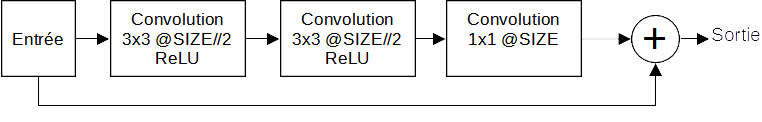

In [ ]:
def resblock(in_, size):
    #Compléter
    return in_+x

Proposer un réseau de plus de 30 couches utilisant les blocs résiduels et lancer l'entraînement. 

In [ ]:
#Proposez une fonction basée sur les résidus réduisant la taille des cartes de caractéristiques.
def resblock_div(in_, size):
    #Compléter
    return x1+x2

def resnet(nn):
    x = in_ = tf.keras.Input(shape=(SIZE,SIZE,3,))
    x = layers.Conv2D(kernel_size=3, filters=64, strides=1, activation='relu', padding="same")(x)
    x = layers.Conv2D(kernel_size=3, filters=128, strides=1, activation=None, padding="same")(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

    x = resblock(x, size=128)
    x = resblock(x, size=128)
    x = resblock_div(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock_div(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock_div(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)
    x = resblock(x, size=256)

    x = layers.GlobalAveragePooling2D(name="gp")(x)
  
    x = layers.Dense(2048, activation='relu', name="FC0")(x)
    x = layers.Dense(2048, activation='relu', name="FC1")(x)
    x = layers.Dense(nn, name="FC2")(x)
 
    return models.Model(inputs=in_, outputs=x)

#Entrainer votre modèle. 



---

---

---







#Annexe - Générateur & Séquence

Evidemment nous ne sommes pas obligés de travailler avec des objets de type Dataset. Il est également possible de transmettre à la fonction 'fit' des générateurs ou séquences qui peuvent être définis comme suit : 

In [ ]:

import random
import cv2
from scipy import ndimage

random.seed(42)
batch_size=16
EPOCH=25

colorsub = np.expand_dims(np.expand_dims(np.array([  123.68, 116.779,103.939]), axis=0), axis=0)#BGR.

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_link,  batch_size=128,  shuffle=True, size=128, data_aug = False):
        self.batch_size = batch_size
        self.data = {}
        self.size=size
        self.auto_mode=False
        self.data_aug=data_aug
        chemin = data_link[0]
        labels = data_link[1]

        for i, ch in enumerate(chemin):
            img = cv2.imread(ch)
            self.data[i] = [(cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_LINEAR)).astype(np.uint8), labels[i]]
        self.indices = list(self.data.keys())
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def aug(self, img):
      if not(self.data_aug):
        return img
      #if random.random()<0.1:Z
      #  img = ndimage.rotate(img, random.randint(0,360), reshape=False)
      mode = random.randint(0, 8)
      if mode == 0:
          pass
      elif mode == 1:
          img= np.flipud(np.rot90(img))
      elif mode == 2:
          img=  np.flipud(img)
      elif mode == 3:
          img=  np.rot90(img, k=3)
      elif mode == 4:
          img=  np.flipud(np.rot90(img, k=2))
      elif mode == 5:
          img=  np.rot90(img)
      elif mode == 6:
          img=  np.rot90(img, k=2)
      elif mode == 7:
          img=  np.flipud(np.rot90(img, k=3)) 
      return img

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        keys = [self.indices[k] for k in index]
        return self.__get_data(keys)

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, keys):

        size_=(self.size,self.size)
        X = np.empty((self.batch_size, size_[0], size_[1], 3))
        y =  np.empty((self.batch_size))
        for i, id in enumerate(keys):
            X[i,], y[i]  = self.aug(self.data[id][0]- colorsub), self.data[id][1]

        if self.auto_mode:
          return X, X
        else:
          return X, y
